In [ ]:
# Project Ideas...
# For piano pieces, left/Right hand distinguisher, melody/submelody/not melody distinguisher
# Take piano pieces by the measure/beat, compress each into a vector and use a language model like structure to generate music?
# Some sort of structure/motif parser

# left/right hand distinguisher
# Mp3 to midi

In [77]:
#@title Setup
!pip install mido
from mido import MidiFile
import mido
import numpy as np
from typing import Union

import librosa
import matplotlib.pyplot as plt
from copy import deepcopy

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [ ]:
#@title Audio Parsing

filepath = 'symphonic dance 1.mp3'

signal, sample_rate = librosa.load(filepath)
fft = np.fft.fft(signal)
# magnitude = np.abs(fft)
# frequency = np.linspace(0, sample_rate, len(magnitude))
# left_frequency = frequency[:len(frequency) // 2]
# left_magnitude = frequency[:len(magnitude) // 2]

n_fft = 2048
hop_length = 512
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# lib.display.waveshow(signal, sr=sample_rate)
# plt.plot(frequency, magnitude)
# librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)

In [3]:
#@title MIDI Parsing
# https://mido.readthedocs.io/en/stable/files/midi.html?highlight=time#about-the-time-attribute
# https://music.stackexchange.com/questions/99362/time-in-midi-files
# https://cmtext.indiana.edu/MIDI/chapter3_controller_change2.php

def parse_midi(filepath: str, debug: bool = False) -> tuple[np.ndarray]:
    midi = MidiFile(filepath)
    ticks_per_beat = midi.ticks_per_beat
    track = mido.merge_tracks(midi.tracks)

    time_signatures = []    # [symbol, time, realtime]
    key_signatures = []     # [key, time, realtime]
    tempos = []             # [tempo, time, realtime]
    pedals = []             # [on time, duration, on realtime, duration realtime]
    notes = []              # [note, velocity, start time, duration, start realtime, duration realtime]
    time = 0                # in terms of ticks/PPQ, invariant to tempo
    real_time = 0           # in seconds

    curr_notes = {}
    def parse_note(message) -> None:
        if message.velocity > 0:
            notes.append([message.note, message.velocity, time, -1, real_time, -1])
            curr_notes[message.note] = len(notes) - 1
        elif message.note in curr_notes:
            i = curr_notes[message.note]
            notes[i][3] = time - notes[i][2]
            notes[i][5] = real_time - notes[i][4]
            del curr_notes[message.note]

    def parse_tempo(message) -> None:
        if len(tempos) > 0 and tempos[-1][1] == time:
            tempos[-1][0] = message.tempo
        else:
            tempos.append([message.tempo, time, real_time])

    def parse_pedal(message) -> None:
        on = message.value >= 64
        if on:
            if len(pedals) > 0 and pedals[-1][1] == 0:
                pedals[-1][0] = time
                pedals[-1][1] = -1
                pedals[-1][2] = real_time
            else:
                pedals.append([time, -1, real_time, -1])
        elif pedals[-1][1] == -1:
            pedals[-1][1] = time - pedals[-1][0]
            pedals[-1][3] = real_time - pedals[-1][2]

    def parse_time_signature(message) -> None:
        symbol = f'{message.numerator}/{message.denominator}'
        if len(time_signatures) > 0 and time_signatures[-1][1] == time:
            time_signatures[-1][0] = symbol
        else:
            time_signatures.append([symbol, time, real_time])

    def parse_key_signature(message) -> None:
        if len(key_signatures) > 0 and key_signatures[-1][1] == time:
            key_signatures[-1][0] = message.key
        else:
            key_signatures.append([message.key, time, real_time])

    for i, message in enumerate(track):
        time += message.time
        if len(tempos) > 0:
            real_time += mido.tick2second(message.time, ticks_per_beat, tempos[-1][0])
        instruction = message.type

        if instruction == 'note_on':
            parse_note(message)
        elif instruction == 'set_tempo':
            parse_tempo(message)
        elif instruction == 'control_change' and message.control == 64:
            parse_pedal(message)
        elif instruction == 'time_signature':
            parse_time_signature(message)
        elif instruction == 'key_signature':
            parse_key_signature(message)
        elif debug:
            print(message)
    # assert len(curr_notes) == 0
    # notes = [x for x in notes if x[3] > 0]  # Zero-length notes
    return np.array(notes), np.array(pedals), np.array(tempos), key_signatures, time_signatures


def notes_to_chords(notes: np.ndarray) -> tuple[list[np.ndarray], list[int]]:
    chords = []
    indices = []
    time = 0
    curr_chord = []
    index = 0
    for i, note in enumerate(notes[:, :3].astype(int)):
        curr_note = note[0]
        curr_time = note[2]
        if time == curr_time:
            curr_chord.append(curr_note)
        else:
            if i > 0:
                chords.append(np.array(sorted(curr_chord)))
                indices.append(index)
                index = i
            curr_chord = [curr_note]
        time = curr_time
    return chords, indices

In [4]:
notes, pedals, tempos, key_signatures, time_signatures = parse_midi('symphonic dance 1.mid')

In [5]:
chords, indices = notes_to_chords(notes)

In [ ]:
cpdef inline float interval_playability(interval: float, f1: int, f2: int, right_hand: bool = True):

In [108]:
interval_playability(key_distance('Eb3', 'Gb4'), 4, 0, False)

0.018181540071964264

In [100]:
key_distance('Eb3', 'Gb4', True)

20.400001525878906

In [132]:
#@title Physical Chord Modelling, Cython

%%cython
import numpy as np
cimport numpy as cnp
cnp.import_array()

cdef float white_key_len = 33 / 14         # Length of a white key
cdef float black_key_len = 1               # Length of a black key
cdef float black_key_offset = 1.45         # Distance from C to C#
cdef float octave_len = white_key_len * 7

# key.left, assuming C.left is 0
int_positions = {
    0: 0,                                                       # C
    1: black_key_offset,                                        # C#
    2: white_key_len,                                           # D
    3: 3 * white_key_len - black_key_offset - black_key_len,    # Eb
    4: 2 * white_key_len,                                       # E
    5: 3 * white_key_len,                                       # F
    6: 3 * white_key_len + black_key_offset,                    # F#
    7: 4 * white_key_len,                                       # G
    8: (9 * white_key_len - black_key_len) / 2,                 # Ab
    9: 5 * white_key_len,                                       # A
    10: 7 * white_key_len - black_key_offset - black_key_len,   # Bb
    11: 6 * white_key_len,                                      # B
}
letter_to_int = {
    'C': 0,
    'D': 2,
    'E': 4,
    'F': 5,
    'G': 7,
    'A': 9,
    'B': 11
}
cdef list[str] letters = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']
cpdef inline str int_to_key(k: int):
    cdef int octave, base_int
    cdef str letter

    octave, base_int = divmod(k, 12)
    letter = letters[base_int]
    return f'{letter}{octave}'


cpdef inline int key_to_int(key: str):
    cdef int base, i, len_key, octave
    cdef char letter

    base = letter_to_int[key[0]]
    i = 1
    len_key = len(key)
    if i == len_key:
        return base
    letter = key[i]
    while letter == b'#' or letter == b'b':
        base += 1 if letter == b'#' else -1
        i += 1
        if i == len_key:
            return base
        letter = key[i]
    octave = int(key[i:])
    return octave * 12 + base


cpdef inline int is_white_key(input_key: Union[str, int]):
    cdef int key
    key = key_to_int(input_key) if isinstance(input_key, str) else input_key
    key = key % 12
    return key in letter_to_int.values()


cpdef inline float key_len(key: Union[str, int]):
    return white_key_len if is_white_key(key) else black_key_len


cpdef inline float key_distance(input_k1: Union[str, int], input_k2: Union[str, int],
                                use_average: bool = True,
                                left_outer: bool = False, right_outer: bool = False):
    """Find physical distance between two piano keys.

    left_outer: use the leftmost/rightmost position of the left key
    right_outer: use the leftmost/rightmost position of the right key
    use_average: use the middle position of the left/right key
    """
    cdef int k1, k2, octave1, octave2, octave_diff
    cdef float left_limit, right_limit

    k1 = key_to_int(input_k1) if isinstance(input_k1, str) else input_k1
    k2 = key_to_int(input_k2) if isinstance(input_k2, str) else input_k2
    (k1, k2) = (k1, k2) if k1 <= k2 else (k2, k1)

    octave1, k1 = divmod(k1, 12)
    octave2, k2 = divmod(k2, 12)
    octave_diff = octave2 - octave1

    left_limit = int_positions[k1]
    right_limit = int_positions[k2]
    if use_average:
        left_limit += key_len(k1) / 2
        right_limit += key_len(k2) / 2
    else:
        if not left_outer:
            left_limit += key_len(k1)
        if right_outer:
            right_limit += key_len(k2)
    return right_limit - left_limit + octave_diff * octave_len


# finger_distances[i, j] = farthest distance reachable from finger i (left) to j (right)
# assumes thumb can touch the piano during the distance measurement
cdef cnp.ndarray right_finger_distances = np.array(
    [[4.5,  16.2, 19,   19.4, 20.5],
     [12.2, 1.3,  8.6,  10.7, 14.3],
     [12.6, 7.2,  1.5,  7.9,  12.8],
     [10.8, 6.3,  2.3,  1.3,  8.1],
     [8,    2,    0,    0,    1.1]]
)
cdef cnp.ndarray left_finger_distances = right_finger_distances.T

# finger_comfortable_range[i, j] = min comfortable distance from finger i to j
# finger_comfortable_range[j, i] = max comfortable distance from finger i to j
cdef cnp.ndarray finger_comfortable_range = np.array(
    [[2.5,  2.7, 6.5, 8,   10],
     [4.8,  0.7, 2,   4.5, 6],
     [9,    4.1, 0.7, 2.8, 4],
     [11.2, 6.5, 3.5, 0.7, 2.1],
     [15,   8.6, 5.7, 3.5, 0.5]]
)


################################################################################
# Playability
################################################################################
cpdef inline float interval_playability(interval: float, f1: int, f2: int, right_hand: bool = True):
    """Return a score in [0, 1] indicating how comfortably an interval played by
    fingers f1 (left) and f2 (right) on a given hand.

    Unplayable intervals have score -inf.
    """
    cdef float i1, i2, max_limit, penalty

    i1 = finger_comfortable_range[f1, f2]
    i2 = finger_comfortable_range[f2, f1]
    if right_hand:
        max_limit = right_finger_distances[f1, f2]
    else:
        max_limit = left_finger_distances[f1, f2]
    penalty = 1 if ((f1 <= f2) == right_hand) else 0.5

    i1, i2 = min(i1, i2), max(i1, i2)
    if i1 <= interval <= i2:
        return penalty
    elif 0 <= interval < i1:
        return penalty * interval / i1
    elif i2 < interval <= max_limit:
        return penalty * (max_limit - interval) / (max_limit - i2)
    return -np.inf


cpdef inline float chord_note_playability(finger: int, sorted_chord: cnp.ndarray,
                                          fingering: list[int], right_hand: bool = True):
    """Similar to interval_playability, but for a given finger playing a
    certain index of a sorted_chord.
    """
    cdef float score, penalty, interval, playability
    cdef int index, chord_key, i, f, key, j
    cdef bint is_white

    index = len(fingering)
    if index == 0:
        return 1
    score = np.infty

    chord_key = sorted_chord[index]
    for i in range(index):
        f = fingering[i]
        key = sorted_chord[i]

        penalty = 1
        if f == finger:
            is_white = is_white_key(key)
            if is_white != is_white_key(chord_key):
                return -np.infty

            for j in range(key, chord_key):
                if j not in sorted_chord and (j % 12 in letter_to_int.values()) == is_white:
                    return -np.infty
            penalty = 0.8

        interval = key_distance(key, chord_key, use_average=True)
        playability = interval_playability(interval, f, finger, right_hand) * penalty
        if playability < score:
            score = playability
    return score

cdef inline list[float] _optimal_chord_fingering(sorted_chord: cnp.ndarray,
                                                  right_hand: bool,
                                                  first_note: int,
                                                  fingering: list[float]):
    """Top-down dynamic programming algorithm for maximizing playability."""
    cdef list[float] max_fingering
    cdef int n, f
    cdef float max_score, new_score, score

    n = sorted_chord.shape[0]
    max_score = -np.inf
    max_fingering = []

    for f in range(5):
        score = chord_note_playability(f, sorted_chord, fingering, right_hand)
        if score == -np.inf:
            continue
        if first_note == n - 1:
            new_fingering, new_score = fingering + [f], score
        else:
            new_fingering = _optimal_chord_fingering(sorted_chord, right_hand,
                                                      first_note + 1,
                                                      fingering + [f])
            new_score = new_fingering.pop()
            new_score = min(score, new_score)

        if new_score > max_score:
            max_fingering = new_fingering
            max_score = new_score
    return max_fingering + [max_score]


cdef inline list[float] optimal_chord_fingering(input_sorted_chord: Union[cnp.ndarray, list[str]],
                                                 right_hand: bool = True):
    """Return a fingering of the same shape of sorted_chord that maximizes the
    playability score of the given chord. If unplayable, the array is all -1.

    Also returns the playability score.
    """
    cdef cnp.ndarray sorted_chord
    cdef float opt_score

    if isinstance(input_sorted_chord[0], str):
        sorted_chord = np.array([key_to_int(x) for x in input_sorted_chord])
    else:
        sorted_chord = input_sorted_chord

    return _optimal_chord_fingering(sorted_chord, right_hand, 0, [])


def memoized_optimal_chord_fingering(sorted_chord: Union[np.ndarray, list[str]],
                                     right_hand: bool = True) -> tuple[np.ndarray, float]:
    stored_optimal_chord_fingerings = {}
    s = str(sorted_chord) + str(right_hand)
    if s in stored_optimal_chord_fingerings:
        return stored_optimal_chord_fingerings[s]
    else:
        fingering = optimal_chord_fingering(sorted_chord, right_hand)
        score = fingering.pop()
        stored_optimal_chord_fingerings[s] = (np.array(fingering).astype(int), score)
        return stored_optimal_chord_fingerings[s]

Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_b8e93bdf88b51d01dacd8e0c598b2ec7bf9430c6.c:1257:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [130]:
#@title Physical Chord Modelling

# Data measured in cm
white_key_len = 33 / 14         # Length of a white key
black_key_len = 1               # Length of a black key
black_key_offset = 1.45         # Distance from C to C#
octave_len = white_key_len * 7

# key.left, assuming C.left is 0
int_positions = {
    0: 0,                                                       # C
    1: black_key_offset,                                        # C#
    2: white_key_len,                                           # D
    3: 3 * white_key_len - black_key_offset - black_key_len,    # Eb
    4: 2 * white_key_len,                                       # E
    5: 3 * white_key_len,                                       # F
    6: 3 * white_key_len + black_key_offset,                    # F#
    7: 4 * white_key_len,                                       # G
    8: (9 * white_key_len - black_key_len) / 2,                 # Ab
    9: 5 * white_key_len,                                       # A
    10: 7 * white_key_len - black_key_offset - black_key_len,   # Bb
    11: 6 * white_key_len,                                      # B
}

letter_to_int = {
    'C': 0,
    'D': 2,
    'E': 4,
    'F': 5,
    'G': 7,
    'A': 9,
    'B': 11
}
letters = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']
def int_to_key(k: int) -> str:
    octave, base_int = divmod(k, 12)
    letter = letters[base_int]
    return f'{letter}{octave}'

def key_to_int(key: str) -> int:
    base = letter_to_int[key[0]]
    i = 1
    if i == len(key):
        return base
    while key[i] in '#b':
        base += 1 if key[i] == '#' else -1
        i += 1
        if i == len(key):
            return base
    octave = int(key[i:])
    return octave * 12 + base

def is_white_key(key: Union[str, int]) -> int:
    if isinstance(key, str):
        key = key_to_int(key)
    return (key % 12) in letter_to_int.values()

def key_len(key: Union[str, int]) -> int:
    return white_key_len if is_white_key(key) else black_key_len

def key_distance(k1: Union[str, int], k2: Union[str, int],
                 use_average: bool = True,
                 left_outer: bool = False, right_outer: bool = False) -> float:
    """Find physical distance between two piano keys.

    left_outer: use the leftmost/rightmost position of the left key
    right_outer: use the leftmost/rightmost position of the right key
    use_average: use the middle position of the left/right key
    """
    if isinstance(k1, str):
        k1 = key_to_int(k1)
    if isinstance(k2, str):
        k2 = key_to_int(k2)

    (k1, k2) = (k1, k2) if k1 <= k2 else (k2, k1)
    octave1, k1 = divmod(k1, 12)
    octave2, k2 = divmod(k2, 12)
    octave_diff = octave2 - octave1

    left_limit = int_positions[k1]
    right_limit = int_positions[k2]
    if use_average:
        left_limit += key_len(k1) / 2
        right_limit += key_len(k2) / 2
    else:
        if not left_outer:
            left_limit += key_len(k1)
        if right_outer:
            right_limit += key_len(k2)
    return right_limit - left_limit + octave_diff * octave_len


# finger_distances[i, j] = farthest distance reachable from finger i (left) to j (right)
# assumes thumb can touch the piano during the distance measurement
right_finger_distances = np.array(
    [[4.5,  16.2, 19,   19.4, 20.5],
     [12.2, 1.3,  8.6,  10.7, 14.3],
     [12.6, 7.2,  1.5,  7.9,  12.8],
     [10.8, 6.3,  2.3,  1.3,  8.1],
     [8,    2,    0,    0,    1.1]]
)
left_finger_distances = right_finger_distances.T

# finger_comfortable_range[i, j] = min comfortable distance from finger i to j
# finger_comfortable_range[j, i] = max comfortable distance from finger i to j
finger_comfortable_range = np.array(
    [[2.5,  2.7, 6.5, 8,   10],
     [4.8,  0.7, 2,   4.5, 6],
     [9,    4.1, 0.7, 2.8, 4],
     [11.2, 6.5, 3.5, 0.7, 2.1],
     [15,   8.6, 5.7, 3.5, 0.5]]
)


################################################################################
# Playability
################################################################################
def interval_playability(interval: float, f1: int, f2: int, right_hand: bool = True) -> float:
    """Return a score in [0, 1] indicating how comfortably an interval played by
    fingers f1 (left) and f2 (right) on a given hand.

    Unplayable intervals have score -inf.
    """
    i1 = finger_comfortable_range[f1, f2]
    i2 = finger_comfortable_range[f2, f1]
    if right_hand:
        max_limit = right_finger_distances[f1, f2]
    else:
        max_limit = left_finger_distances[f1, f2]
    penalty = 1 if ((f1 <= f2) == right_hand) else 0.5
    # print(f'interval={interval}, limit={max_limit}, f1={f1}, f2={f2}, right_hand={right_hand}, penalty={penalty}')
    i1, i2 = min(i1, i2), max(i1, i2)
    if i1 <= interval <= i2:
        return penalty
    elif 0 <= interval < i1:
        return penalty * interval / i1
    elif i2 < interval <= max_limit:
        return penalty * (max_limit - interval) / (max_limit - i2)
    return -np.inf


# def chord_note_playability(index: int, finger: int, sorted_chord: np.ndarray,
#                            right_hand: bool = True) -> float:
#     """Similar to interval_playability, but for a given finger playing a
#     certain index of a sorted_chord.
#     """
#     assert sorted_chord[1, index] == -1
#     # print(f'{index}, {finger}, {sorted_chord.tolist()}, {right_hand}')
#     if index == 0:
#         return 1
#     sum = 0
#     counter = 0
#     for i, f in enumerate(sorted_chord[1, :]):
#         if f == -1:
#             assert i >= index
#             break
#         key1 = sorted_chord[0, i]
#         key2 = sorted_chord[0, index]
#         penalty = 1

#         if f == finger:
#             is_white = is_white_key(key1)
#             j1 = sorted_chord[0, min(i, index)]
#             j2 = sorted_chord[0, max(i, index)]

#             # The same finger can't play a black & white note simultaneously
#             if is_white != is_white_key(key2):
#                 # print('black/white')
#                 return -np.infty
#             # The same finger can only play adjacent white/black note clusters
#             if is_white and any(j not in sorted_chord for j in range(j1, j2) if j in letter_to_int.values()):
#                 # print('white note cluster')
#                 return -np.infty
#             if not is_white and any(j not in sorted_chord for j in range(j1, j2) if j not in letter_to_int.values()):
#                 # print('black note cluster')
#                 return -np.infty
#             penalty = 0.8

#         interval = key_distance(key1, key2, True)
#         # print(interval_playability(interval, f, finger, right_hand) * penalty)
#         sum += interval_playability(interval, f, finger, right_hand) * penalty
#         counter += 1
#     return sum / counter


# def optimal_chord_fingering(sorted_chord: Union[np.ndarray, list[str]],
#                             right_hand: bool = True) -> tuple[np.ndarray, float]:
#     """Return a fingering of the same shape of sorted_chord that maximizes the
#     playability score of the given chord. If unplayable, the array is all -1.

#     Also returns the playability score.
#     """
#     if isinstance(sorted_chord[0], str):
#         sorted_chord = np.array([key_to_int(x) for x in sorted_chord])
#     n = sorted_chord.shape[0]
#     row_finger = np.empty((1, n))
#     row_finger.fill(-1)
#     sorted_chord = np.concatenate([sorted_chord.reshape(1, n), row_finger], axis=0).astype(int)

#     def _optimal_chord_fingering(first_note: int, chord: np.ndarray) -> tuple[np.ndarray, float]:
#         """Top-down dynamic programming algorithm for maximizing playability."""
#         max_score = -np.inf
#         max_i = -1
#         # a = int_to_key(chord[0, first_note])
#         # print(f'Start {a}, {first_note}')
#         iterator = range(5) if right_hand else range(4, -1, -1)
#         if first_note == n - 1:
#             new_chord = deepcopy(chord)
#             for i in iterator:
#                 score = chord_note_playability(first_note, i, chord, right_hand)
#                 # print(f'{first_note}, {i}, {chord.tolist()}, {right_hand} = {score}')
#                 if score > max_score:
#                     max_i = i
#                     max_score = score
#             new_chord[1, first_note] = max_i
#             # print(f'End {a}, {first_note}\n')
#             return new_chord, max_score
#         else:
#             max_chord = None
#             for i in iterator:
#                 score = chord_note_playability(first_note, i, chord, right_hand)
#                 # print(f'{first_note}, {i}, {chord.tolist()}, {right_hand} = {score}')
#                 if score == -np.infty:
#                     continue

#                 new_chord = deepcopy(chord)
#                 new_chord[1, first_note] = i
#                 curr_chord, curr_score = _optimal_chord_fingering(first_note + 1, new_chord)
#                 curr_score = min(curr_score, score)
#                 if curr_score > max_score:
#                     max_i = i
#                     max_score = curr_score
#                     max_chord = curr_chord
#             # print(f'End {a}, {first_note}\n')
#             # print(f'optimal {first_note}: {max_i}')
#             return max_chord, max_score

#     final_chord, final_score = _optimal_chord_fingering(0, sorted_chord)
#     if final_score == -np.inf:
#         return sorted_chord[1, :], final_score

#     return final_chord[1, :], final_score


def chord_note_playability(finger: int, sorted_chord: np.ndarray,
                           fingering: list[int], right_hand: bool = True) -> float:
    """Similar to interval_playability, but for a given finger playing a
    certain index of a sorted_chord.
    """
    index = len(fingering)
    # assert all(x == -1 for x in fingering[index:])
    if index == 0:
        return 1
    score = np.infty

    chord_key = sorted_chord[index]
    for i in range(index):
        f = fingering[i]
        key = sorted_chord[i]

        penalty = 1
        if f == finger:
            is_white = is_white_key(key)
            # The same finger can't play a black & white note simultaneously
            if is_white != is_white_key(chord_key):
                return -np.infty
            # The same finger can only play adjacent white/black note clusters
            if is_white and any(j not in sorted_chord for j in range(key, chord_key) \
                                if j % 12 in letter_to_int.values()):
                return -np.infty
            if not is_white and any(j not in sorted_chord for j in range(key, chord_key) \
                                    if j % 12 not in letter_to_int.values()):
                return -np.infty
            penalty = 0.8

        interval = key_distance(key, chord_key, use_average=True)
        playability = interval_playability(interval, f, finger, right_hand) * penalty
        if playability < score:
            score = playability
    return score


def optimal_chord_fingering(sorted_chord: Union[np.ndarray, list[str]],
                            right_hand: bool = True) -> tuple[np.ndarray, float]:
    """Return a fingering of the same shape of sorted_chord that maximizes the
    playability score of the given chord. If unplayable, the array is all -1.

    Also returns the playability score.
    """
    if isinstance(sorted_chord[0], str):
        sorted_chord = np.array([key_to_int(x) for x in sorted_chord])
    n = sorted_chord.shape[0]

    def _optimal_chord_fingering(first_note: int, fingering: list[int]) -> tuple[list[int], float]:
        """Top-down dynamic programming algorithm for maximizing playability."""
        # print(f'OPT, first_note={first_note}, fingering={fingering}')
        max_score = -np.inf
        max_fingering = None

        for f in range(5):
            score = chord_note_playability(f, sorted_chord, fingering, right_hand)
            if score == -np.inf:
                continue
            if first_note == n - 1:
                new_fingering, new_score = fingering + [f], score
            else:
                new_fingering, new_score = _optimal_chord_fingering(first_note + 1, fingering + [f])
                new_score = min(score, new_score)

            if new_score > max_score:
                max_fingering = new_fingering
                max_score = new_score
        # print(f'RESULT: {max_fingering}, {max_score}')
        return max_fingering, max_score

    fingering, score = _optimal_chord_fingering(0, [])
    return np.array(fingering), score


def memoized_optimal_chord_fingering(sorted_chord: Union[np.ndarray, list[str]],
                                     right_hand: bool = True) -> tuple[np.ndarray, float]:
    stored_optimal_chord_fingerings = {}
    s = str(sorted_chord) + str(right_hand)
    if s in stored_optimal_chord_fingerings:
        return stored_optimal_chord_fingerings[s]
    else:
        stored_optimal_chord_fingerings[s] = optimal_chord_fingering(sorted_chord, right_hand)
        return stored_optimal_chord_fingerings[s]


def chord_fingerings(sorted_chord: Union[np.ndarray, list[str]],
                     available_fingers: list[int] = [],
                     right_hand: bool = True) -> tuple[np.ndarray, float]:
    """Return all possible fingerings of the same shape of sorted_chord, sorted
    by playability score in descending order.
    """
    # assert all(x in [0, 1, 2, 3, 4] for x in available_fingers)
    if len(available_fingers) == 0:
        available_fingers = np.array([0, 1, 2, 3, 4])
    if isinstance(sorted_chord[0], str):
        sorted_chord = np.array([key_to_int(x) for x in sorted_chord])
    n = sorted_chord.shape[0]
    fingerings = []

    def _optimal_chord_fingering(first_note: int, fingering: list[int]) -> tuple[list[int], float]:
        """Top-down dynamic programming algorithm for playability."""
        new_fingering, new_score = [], -np.inf
        for f in available_fingers:
            score = chord_note_playability(f, sorted_chord, fingering, right_hand)
            if score == -np.inf:
                continue
            if first_note == n - 1:
                new_fingering, new_score = fingering + [f], score
            else:
                new_fingering, new_score = _optimal_chord_fingering(first_note + 1, fingering + [f])
                new_score = min(score, new_score)
            if new_score != -np.inf:
                fingerings.append((new_fingering, new_score))

        return new_fingering, new_score

    _, _ = _optimal_chord_fingering(0, [])
    return sorted(fingerings, key=lambda x: x[1], reverse=True)

In [56]:
chord_note_playability(1, np.array([0, 3, 11]), [0])

1.0

In [41]:
key_distance('E4', 'D5', True)

14.14285659790039

In [63]:
optimal_chord_fingering(['C0', 'G0', 'C1'], False)

(array([4, 1, 0]), 0.7222222089767456)

In [62]:
optimal_chord_fingering(['C0', 'D0', 'F0', 'G0', 'A', 'C1', 'D1'])

(array([], dtype=int64), -inf)

In [ ]:
parse_chord(['C0', 'F', 'G0', 'C1'], -1)

([], array([0, 1, 2, 4]), 0.7945666199928616, 0)

In [133]:
parse_chord(['Eb3', 'Bb3', 'Gb4', 'Eb5', 'Gb5', 'Bb5', 'Eb6'])

(array([4, 1, 0]), array([0, 1, 2, 4]), 0.018181540071964264, 3)

In [125]:
#@title Passage Modelling V1

def parse_chord(sorted_chord: Union[np.ndarray, list[str]],
                direction: int = 0) -> tuple[list[int], list[int], float, int]:
    """Split a chord into the ideal left/right hand fingering.
    Also return the associated playability score and the index of the chord
    where the chord split is made.
    Raise a ValueError if the given chord cannot be played by left + right hand.
    """
    if isinstance(sorted_chord[0], str):
        sorted_chord = np.array([key_to_int(x) for x in sorted_chord])

    n = len(sorted_chord)
    if direction == 0:
        m = n // 2
        start_i = np.argpartition(sorted_chord, m)[m]  # Index of median
    elif direction > 0:
        start_i = n
    else:
        start_i = 0

    if n == 1:
        if sorted_chord[0] >= 60:
            return [], [0], 1, 0
        return [0], [], 1, 1

    def chord_split(i: int) -> tuple:
        if i == 0:
            right_fingering, right_score = memoized_optimal_chord_fingering(sorted_chord, True)
            must_go_up = right_score == -np.inf
            must_go_down = False
            return [], right_fingering, 1, right_score, must_go_up, must_go_down
        if i == len(sorted_chord):
            left_fingering, left_score = memoized_optimal_chord_fingering(sorted_chord, False)
            must_go_up = False
            must_go_down = left_score == -np.inf
            return left_fingering, [], left_score, 1, must_go_up, must_go_down

        left = sorted_chord[:i]
        right = sorted_chord[i:]
        # print(f'{left}, {right}')
        left_fingering, left_score = memoized_optimal_chord_fingering(left, False)
        right_fingering, right_score = memoized_optimal_chord_fingering(right, True)
        must_go_up = right_score == -np.inf
        must_go_down = left_score == -np.inf
        return left_fingering, right_fingering, left_score, right_score, must_go_up, must_go_down

    direction = None
    while start_i in range(n + 1):
        left_fingering, right_fingering, left_score, right_score, must_go_up, must_go_down = chord_split(start_i)
        # print(f'{sorted_chord[:start_i]}, {sorted_chord[start_i:]}, {must_go_up}, {must_go_down}')

        if not must_go_up and not must_go_down:
            break
        if must_go_up and must_go_down:
            raise ValueError()

        if direction is None:
            direction = must_go_up
        elif direction != must_go_up:
            raise ValueError()

        if must_go_up:
            start_i += 1
        else:
            start_i -= 1

    return left_fingering, right_fingering, min(left_score, right_score), start_i


def int_to_position(k: int, average: bool = True) -> float:
    octave, k = divmod(k, 12)
    offset = white_key_len if is_white_key(k) else black_key_len
    if average:
        return octave * octave_len + int_positions[k] + offset / 2
    return octave * octave_len + int_positions[k]


def get_hand_position(chord: Union[list[int], list[str]], fingering: list[int], right_hand: bool) -> float:
    """Return the predicted hand position (in cm, offsetted from C0) of the hand,
    given it is playing an input chord with an input fingering.
    """
    if isinstance(chord[0], str):
        chord = [key_to_int(x) for x in chord]
    assert all(x in range(5) for x in fingering)
    left = fingering[0]
    right = fingering[-1]
    left_limit = int_to_position(left)
    right_limit = int_to_position(right)

    chord_left_position = int_to_position(chord[0])
    chord_right_position = int_to_position(chord[-1])
    offset = finger_comfortable_range[0, 0]
    hand_len = finger_comfortable_range[4, 0] - offset
    if right_hand:
        left_progress = (finger_comfortable_range[left, 0] - offset) / hand_len
        right_progress = (finger_comfortable_range[right, 0] - offset) / hand_len
    else:
        left_progress = 1 - (finger_comfortable_range[left, 0] - offset) / hand_len
        right_progress = 1 - (finger_comfortable_range[right, 0] - offset) / hand_len

    hand_left = chord_left_position - left_progress * hand_len
    hand_right = chord_right_position + (1 - right_progress) * hand_len
    return (hand_left + hand_right) / 2


def parse_chords(chords: list[list[int]], delays: list[float]) -> tuple:
    left_chords = []
    right_chords = []
    left_fingerings = []
    right_fingerings = []

    lh_position = None
    rh_position = None

    def single_note_chord(chord: list[int]) -> tuple:
        min_change = np.infty
        min_finger = None
        min_hand = None
        for finger in range(5):
            curr_lh_position = get_hand_position(chord, [finger], False)
            curr_rh_position = get_hand_position(chord, [finger], True)
            left_change = abs(curr_lh_position - lh_position)
            right_change = abs(curr_rh_position - rh_position)
            if left_change < min_change:
                min_change = left_change
                min_finger = [finger]
                min_hand = 'left'
            if right_change < min_change:
                min_change = right_change
                min_finger = [finger]
                min_hand = 'right'
        if min_hand == 'left':
            left_fingering, right_fingering, score = min_finger, [], 1
            left_chord, right_chord = chord, []
        else:
            left_fingering, right_fingering, score = [], min_finger, 1
            left_chord, right_chord = [], chord
        return left_fingering, right_fingering, score, left_chord, right_chord

    def regular_chord(chord: list[int]) -> tuple:
        if lh_position is not None and rh_position is not None and lh_position < rh_position:
            min_chord_position = int_to_position(np.min(chord))
            max_chord_position = int_to_position(np.max(chord))
            threshold = 0.4
            right_extent = threshold * lh_position + (1 - threshold) * rh_position
            left_extent = (1 - threshold) * lh_position + threshold * rh_position
            if min_chord_position >= right_extent:
                direction = -1
            elif max_chord_position <= left_extent:
                direction = 1
            else:
                direction = 0
            left_fingering, right_fingering, score, j = parse_chord(np.array(chord), direction)
        else:
            left_fingering, right_fingering, score, j = parse_chord(np.array(chord))
        left_chord, right_chord = chord[:j], chord[j:]
        return left_fingering, right_fingering, score, left_chord, right_chord

    def single_note_hand(left_chord: list[int], lh_position: float, left_fingerings: list[list[int]], right_hand: bool) -> float:
        min_change = np.infty
        min_lh_position = None
        min_fingering = None
        for finger in range(5):
            curr_lh_position = get_hand_position(left_chord, [finger], right_hand)
            curr_change = abs(curr_lh_position - lh_position)
            if curr_change < min_change:
                min_change = curr_change
                min_lh_position = curr_lh_position
                min_fingering = [finger]
        # print(f'{i}: Previously {left_fingerings[-1]} at {left_chords[-1]}, best played {left_chord} at {min_fingering}')
        left_fingerings.append(min_fingering)
        return min_lh_position

    for i, chord in enumerate(chords):
        # Parse chord
        if len(chord) == 1 and lh_position is not None and rh_position is not None:
            left_fingering, right_fingering, score, left_chord, right_chord = single_note_chord(chord)
        else:
            try:
                left_fingering, right_fingering, score, left_chord, right_chord = regular_chord(chord)
            except ValueError:
                print(f'Unplayable at {i} / {len(chords)}: {[int_to_key(x) for x in chord.tolist()]}')
                left_chords.append(np.array([]).astype(int))
                right_chords.append(np.array([]).astype(int))
                left_fingerings.append(np.array([]).astype(int))
                right_fingerings.append(np.array([]).astype(int))
                continue
        # print(f'{i}: {left_fingering}, {right_fingering}, {left_chord}, {right_chord}')

        # Parsing left chord
        if len(left_chord) == 1 and lh_position is not None:
            # len(left_chords) > 0 and len(left_chords[-1]) == 1
            lh_position = single_note_hand(left_chord, lh_position, left_fingerings, False)
        else:
            if len(left_chord) != 0:
                new_lh_position = get_hand_position(left_chord, left_fingering, False)
            else:
                new_lh_position = lh_position
            lh_position = new_lh_position
            left_fingerings.append(left_fingering)

        # Parsing right chord
        if len(right_chord) == 1 and rh_position is not None and i >= 1:
            # len(right_chords) > 0 and len(right_chords[-1]) == 1
            rh_position = single_note_hand(right_chord, rh_position, right_fingerings, True)
        else:
            if len(right_chord) != 0:
                new_rh_position = get_hand_position(right_chord, right_fingering, True)
            else:
                new_rh_position = rh_position
            rh_position = new_rh_position
            right_fingerings.append(right_fingering)

        left_chords.append(left_chord)
        right_chords.append(right_chord)

    to_array = lambda lst: [np.array(x).astype(int) for x in lst]
    return to_array(left_chords), to_array(left_fingerings), to_array(right_chords), to_array(right_fingerings)

In [ ]:
get_hand_position([64], [1], False)

91.09285714285714

In [ ]:
int_to_position(key_to_int('E'))

5.892857142857143

In [ ]:
parse_chord(['C0', 'D0', 'E0'])

(array([0]), array([1, 2]), 1.0, 1)

In [134]:
left_chords, left_fingerings, right_chords, right_fingerings = parse_chords(chords, [])

Unplayable at 270 / 2953: ['D3', 'F#4', 'D6', 'A6', 'D7']


In [ ]:
#@title Passage Modelling V2

# def parse_cho

In [110]:
#@title Piano Roll Visualization
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Rectangle

def plot_chords(left_chords: list[np.ndarray], right_chords: list[np.ndarray],
                left_fingerings: list[np.ndarray], right_fingerings: np.ndarray,
                start: int = -1, end: int = np.inf) -> None:
    assert len(left_chords) == len(right_chords)
    n = len(left_chords)
    start = min(n - 1, max(0, start))
    end = min(n, max(1, end))

    plt.clf()
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    plt.grid(which='major', color='#bdbdbd', linestyle='-')
    plt.grid(which='minor', color='lightgrey', linestyle='--')
    plt.minorticks_on()
    plt.ylabel('Note')
    plt.xlabel('Time')
    plt.yticks(range(0, 128, 4), [int_to_key(x) for x in range(0, 128, 4)])
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

    font_size = 7
    left_col = '#1b1bd0'
    right_col = '#d01b1b'
    for i in range(start, end):
        plt.scatter([i] * len(left_chords[i]), left_chords[i], s=0)
        plt.scatter([i] * len(right_chords[i]), right_chords[i], s=0)

        for j, note in enumerate(left_chords[i]):
            ax.add_patch(Rectangle((i - 0.5, note - 0.5), 1, 1,
                                   facecolor=left_col, alpha=0.3))
            plt.text(i, note, left_fingerings[i][j] + 1,
                     ha='center', va='center', c=left_col, size=font_size)

        for j, note in enumerate(right_chords[i]):
            ax.add_patch(Rectangle((i - 0.5, note - 0.5), 1, 1,
                                   facecolor=right_col, alpha=0.3))
            plt.text(i, note, right_fingerings[i][j] + 1,
                     ha='center', va='center', c=right_col, size=font_size)


def plot_chords_timed(left_chords: list[np.ndarray], right_chords: list[np.ndarray],
                      left_fingerings: list[np.ndarray], right_fingerings: np.ndarray,
                      notes: np.ndarray, timing: np.ndarray, indices: list[int],
                      start: int = -1, end: int = np.inf) -> None:
    n = len(left_chords)
    start = min(n - 1, max(0, start))
    end = min(n, max(1, end))

    plt.clf()
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    plt.grid(which='major', color='#bdbdbd', linestyle='-')
    plt.grid(which='minor', color='lightgrey', linestyle='--')
    plt.minorticks_on()
    plt.ylabel('Note')
    plt.xlabel('Time')
    plt.yticks(range(0, 128, 4), [int_to_key(x) for x in range(0, 128, 4)])
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

    font_size = 7
    left_col = '#1b1bd0'
    right_col = '#d01b1b'
    for i in range(start, end):
        time_start = {}
        duration = {}
        for j in range(indices[i], indices[min(i + 1, len(indices) - 1)]):
            note = int(notes[j])
            time_start[note] = timing[j, 0]
            duration[note] = timing[j, 1]

        left_time_start = []
        right_time_start = []
        for j, note in enumerate(left_chords[i]):
            fingering = left_fingerings[i][j]
            ax.add_patch(Rectangle((time_start[note], note - 0.5), duration[note], 1,
                                   facecolor=left_col, alpha=0.3))
            plt.text(time_start[note], note, fingering + 1,
                     ha='center', va='center', c=left_col, size=font_size)
            left_time_start.append(time_start[note])

        for j, note in enumerate(right_chords[i]):
            fingering = right_fingerings[i][j]
            ax.add_patch(Rectangle((time_start[note], note - 0.5), duration[note], 1,
                                   facecolor=right_col, alpha=0.3))
            plt.text(time_start[note], note, fingering + 1,
                     ha='center', va='center', c=right_col, size=font_size)
            right_time_start.append(time_start[note])

        if len(left_time_start) > 0:
            plt.scatter(left_time_start, left_chords[i], s=0)
        if len(right_time_start) > 0:
            plt.scatter(right_time_start, right_chords[i], s=0)

<Figure size 640x480 with 0 Axes>

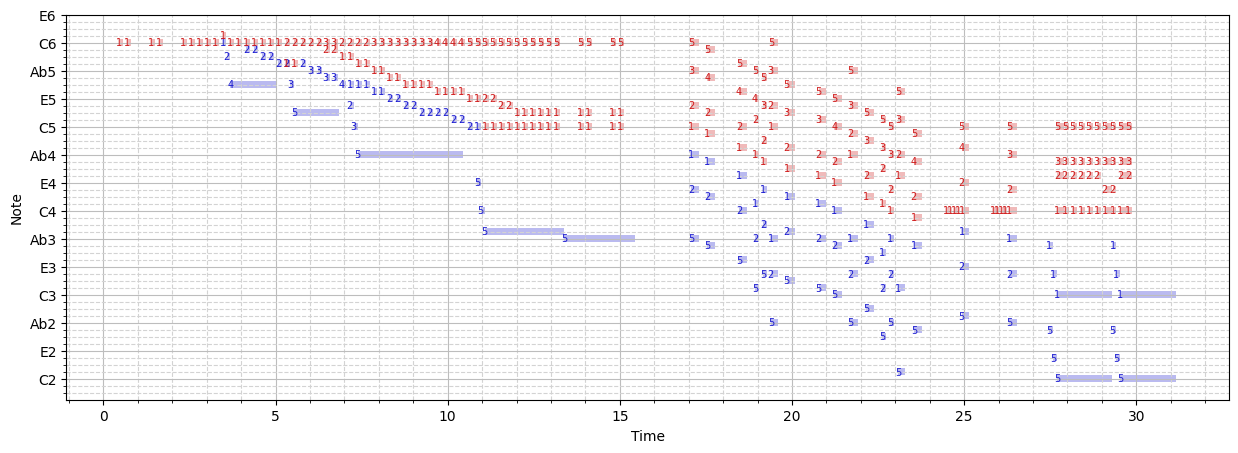

In [111]:
plot_chords_timed(left_chords, right_chords, left_fingerings, right_fingerings,
                  notes[:, 0], notes[:, 4:6], indices, 0, 100)

<Figure size 640x480 with 0 Axes>

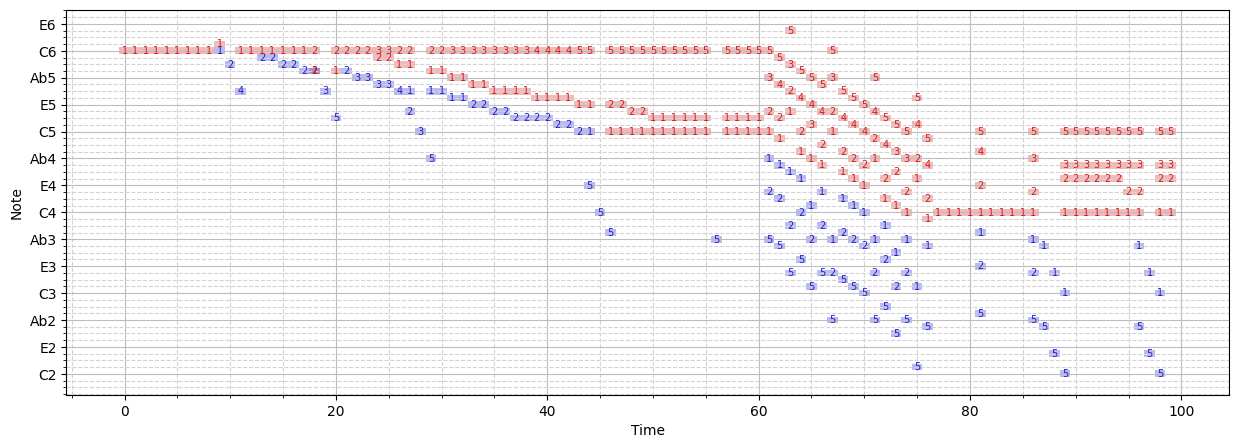

In [ ]:
plot_chords(left_chords, right_chords, left_fingerings, right_fingerings, 0, 100)